In [17]:
!pip install optimus

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 9.5 MB/s eta 0:00:00
  Created wheel for optimus: filename=Optimus-2.1.0-py2.py3-none-any.whl size=50358 sha256=5a7c6ee6f2796c4df15406e024dd1ba99796c350b002fc08625518f3089ab9ec
  Stored in directory: /root/.cache/pip/wheels/91/23/04/3409513ce5381250b0419265f74dc9a2550bf6916c2f5a6d46
  Created wheel for jsmin: filename=jsmin-3.0.1-py3-none-any.whl size=13765 sha256=ebb6ca38e9432e73e85a2069a896491b4f8bb9e40058e94ea480757c7c344819
  Stored in directory: /root/.cache/pip/wheels/05/f8/07/b3579be7c148b787938780bc19f9a0afb51fbe9b89bcd3e2ea
Successfully built optimus jsmin


In [11]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c7d1f18f5873d59b0df6f844f0a97d8a7fadfc9185324c0895c8aab8c5ab66f0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
!pip install  captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 125.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is i

In [1]:
# ========== 0) Setup ==========
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification

OUT_DIR = "plots"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_ID = "tae898/emoberta-base"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Text to explain
TEXT = "I am so happy about your graduation !!"


In [2]:
# ========== 1) Load model & tokenizer ==========
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    output_attentions=True
).to(DEVICE).eval()

id2label = model.config.id2label
label2id = {v: k for k, v in id2label.items()}
class_names = [id2label[i] for i in range(len(id2label))]

print(f"[Utterance]\n{TEXT}\n")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[Utterance]
I am so happy about your graduation !!



In [3]:
# ========== 2) Small helpers ==========
def predict_logits(texts):
    enc = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=256).to(DEVICE)
    with torch.inference_mode():
        out = model(**enc)
    return out.logits

def predict_proba(texts):
    logits = predict_logits(texts)
    probs  = F.softmax(logits, dim=-1)
    return probs.detach().cpu().numpy()

def roberta_merge(tokens, scores=None, skip_special=True):
    """Merge RoBERTa byte-BPE pieces (Ġ) into words; mean-aggregate scores per word."""
    specials = set(tokenizer.all_special_tokens)
    words, vals = [], []
    cur, bag = "", []
    it = zip(tokens, scores) if scores is not None else zip(tokens, [None]*len(tokens))
    for t, s in it:
        if skip_special and t in specials:
            continue
        t2 = t.replace("Ġ", " ")
        if t2.startswith(" "):  # new word
            if cur:
                words.append(cur.strip()); vals.append(np.mean(bag) if bag else 0.0)
            cur, bag = t2, [] if s is None else [s]
        else:
            cur += t2
            if s is not None: bag.append(s)
    if cur:
        words.append(cur.strip()); vals.append(np.mean(bag) if bag else 0.0)
    return (words, np.array(vals, float)) if scores is not None else (words, None)

def drop_specials(tokens, scores=None):
    specials = set(tokenizer.all_special_tokens)
    keep_idx = [i for i,t in enumerate(tokens) if t not in specials]
    toks = [tokens[i] for i in keep_idx]
    if scores is None: return toks, None, keep_idx
    return toks, np.asarray(scores)[keep_idx], keep_idx

In [4]:

# ========== 3) Forward once, basic info ==========
enc = tokenizer(TEXT, return_tensors="pt", truncation=True, padding=True, max_length=256).to(DEVICE)
with torch.inference_mode():
    out = model(**enc)
logits = out.logits[0]
probs  = F.softmax(logits, -1).cpu().numpy()
pred_id = int(np.argmax(probs))
pred_label = id2label[pred_id]
print(f"[Predicted] {pred_label}  |  probs: " + ", ".join(f"{id2label[i]}={probs[i]:.3f}" for i in range(len(probs))))

tokens_bpe = tokenizer.convert_ids_to_tokens(enc["input_ids"][0].tolist())

[Predicted] joy  |  probs: neutral=0.005, joy=0.978, surprise=0.006, anger=0.007, sadness=0.002, disgust=0.001, fear=0.001


In [5]:
# ========== 4) GradientSHAP (token-level) ==========
from captum.attr import GradientShap

emb_layer = model.get_input_embeddings()

def fwd_logits_from_emb(inputs_embeds, attention_mask, target_idx):
    out = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask, return_dict=True)
    return out.logits[:, target_idx]

inp_emb = emb_layer(enc["input_ids"]).detach().requires_grad_(True)
pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
pad_vec = emb_layer(torch.tensor([[pad_id]], device=DEVICE))

# baselines = torch.stack([torch.zeros_like(inp_emb), pad_vec], dim=1)   # (1,2,T,D)
baselines = torch.stack([torch.zeros_like(inp_emb), pad_vec.repeat(1, inp_emb.shape[1], 1)], dim=1).squeeze(0) # (2,T,D)

gs = GradientShap(lambda embs, am: fwd_logits_from_emb(embs, am, pred_id))
attr = gs.attribute(inp_emb, baselines=baselines, additional_forward_args=(enc["attention_mask"],), n_samples=30, stdevs=0.0)
tok_scores_gs = attr.sum(-1)[0].detach().cpu().numpy()
# normalize for display
tok_scores_gs = tok_scores_gs / (np.max(np.abs(tok_scores_gs)) + 1e-12)
toks_nospec, scores_nospec, keep_idx = drop_specials(tokens_bpe, tok_scores_gs)
words_gs, word_scores_gs = roberta_merge(toks_nospec, scores_nospec)

plt.figure(figsize=(max(6, 0.45*len(words_gs)), 3))
plt.bar(range(len(words_gs)), word_scores_gs)
plt.xticks(range(len(words_gs)), words_gs, rotation=45, ha="right")
plt.title(f"GradientSHAP tokens — {pred_label}")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "01_gradshap_tokens.png"), dpi=150); plt.close()

In [6]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import os

# base value: π.χ. ο logit της κλάσης pred_id σε κάποιο baseline
with torch.no_grad():
    base_logit = fwd_logits_from_emb(baselines.mean(0, keepdim=True), enc["attention_mask"], pred_id)
    base_val = float(base_logit.item())

# shap.Explanation από Captum scores
subexp = shap.Explanation(
    values=np.array(word_scores_gs, dtype=float),
    base_values=base_val,
    feature_names=words_gs
)

plt.figure(figsize=(7, 4))
shap.plots.waterfall(subexp, max_display=len(words_gs), show=False)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "gradshap_captum_waterfall.png"), dpi=150)
plt.close()


In [7]:
# ========== Layer Integrated Gradients (LIG): Tokens × Layers (RoBERTa) ==========
# Computes token attributions for the predicted class at:
#   - the embedding module ("Emb")
#   - each transformer block output ("L0" ... "L{N-1}")
#
# Prereqs (defined earlier in the notebook):
#   - model, tokenizer, DEVICE
#   - enc (tokenized input dict with "input_ids" and "attention_mask")
#   - tokens_bpe (tokenizer.convert_ids_to_tokens(enc["input_ids"][0].tolist()))
#   - pred_id (int: predicted class index)
#   - id2label (dict: class index -> name)
#   - OUT_DIR (output folder)
#   - emb_layer = model.get_input_embeddings()
#   - fwd_logits_from_emb(inputs_embeds, attention_mask, target_idx)
#   - drop_specials(tokens, scores=None) -> (tokens_wo_specials, scores_wo_specials, keep_idx)

from captum.attr import LayerIntegratedGradients

SAVE_RAW = True  # Save TxL matrix + token/layer names to disk for reproducibility

# 1) Prepare input embeddings and a simple baseline (zeros)
inp_emb = emb_layer(enc["input_ids"]).detach().requires_grad_(True)  # (1, T, D)
am = enc["attention_mask"]                                           # (1, T)
baseline = torch.zeros_like(inp_emb)                                 # (1, T, D)

# 2) Remove special tokens for visualization and for slicing attributions
toks_nospec, _, keep_idx = drop_specials(tokens_bpe)
toks_nospec = [t.replace("Ġ", " ") for t in toks_nospec]  # nicer display for RoBERTa BPE

# 3) Choose target layers: embeddings + each encoder block output
num_layers = model.config.num_hidden_layers
layers = [("Emb", model.roberta.embeddings)] + [
    (f"L{i}", model.roberta.encoder.layer[i].output) for i in range(num_layers)
]
layer_names = [name for name, _ in layers]

# 4) Compute a Tokens×Layers attribution matrix (TxL)
#    TxL shape: (T_no_special, L+1) where L = num_hidden_layers
TxL = []
for _, target_layer in layers:
    lig = LayerIntegratedGradients(
        lambda embs, msk: fwd_logits_from_emb(embs, msk, pred_id),
        target_layer
    )
    at = lig.attribute(
        inputs=inp_emb,                        # (1, T, D)
        baselines=baseline,                    # (1, T, D)
        additional_forward_args=(am,),         # attention mask
        n_steps=32,                            # 32–64 is a reasonable tradeoff
        internal_batch_size=8
    )  # -> (1, T, D)

    tok_attr = at.sum(-1)[0].detach().cpu().numpy()  # (T,)
    tok_attr = tok_attr[keep_idx]                    # drop special-token positions
    TxL.append(tok_attr)

TxL = np.stack(TxL, axis=1)  # (T_no_special, L+1)

# 5) Optionally save raw artifacts
if SAVE_RAW:
    np.save(os.path.join(OUT_DIR, "LIG_tokens_layers.npy"), TxL)
    with open(os.path.join(OUT_DIR, "LIG_tokens_nospecial.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(toks_nospec))
    with open(os.path.join(OUT_DIR, "LIG_layer_names.txt"), "w", encoding="utf-8") as f:
        f.write(",".join(layer_names))

# 6) Heatmap: Tokens × Layers (normalized to [-1, 1] for display)
V = TxL / (np.max(np.abs(TxL)) + 1e-12)
plt.figure(figsize=(max(6, 0.35 * TxL.shape[0]), 0.42 * TxL.shape[1] + 2))
plt.imshow(V.T, aspect="auto", cmap="bwr", vmin=-1, vmax=1)
plt.yticks(range(len(layer_names)), layer_names)
plt.xticks(range(len(toks_nospec)), toks_nospec, rotation=90)
plt.colorbar(label="LIG (normalized)")
plt.title(f"LIG Tokens×Layers — {id2label[pred_id]}")
plt.tight_layout()
fp_hm = os.path.join(OUT_DIR, "LIG_tokens_layers_heatmap.png")
plt.savefig(fp_hm, dpi=150, bbox_inches="tight")
plt.close()
print("[saved]", fp_hm)

# 7) Per-layer curve: total attribution strength per layer (sum over tokens)
layer_curve_abs = np.sum(np.abs(TxL), axis=0)
layer_curve_abs = layer_curve_abs / (layer_curve_abs.max() + 1e-12)

plt.figure(figsize=(7.5, 3.2))
plt.plot(range(len(layer_names)), layer_curve_abs, marker="o")
plt.xticks(range(len(layer_names)), layer_names)
plt.ylabel("Relative |LIG| intensity")
plt.xlabel("Layer (Emb + L0..)")
plt.title(f"LIG per-layer (sum |attr|) — {id2label[pred_id]}")
plt.grid(alpha=0.2)
plt.tight_layout()
fp_pl = os.path.join(OUT_DIR, "LIG_per_layer_curve.png")
plt.savefig(fp_pl, dpi=150, bbox_inches="tight")
plt.close()
print("[saved]", fp_pl)


[saved] plots/LIG_tokens_layers_heatmap.png
[saved] plots/LIG_per_layer_curve.png


In [8]:
# ========== LGXA (LayerGradientXActivation): Tokens × Layers (RoBERTa/EmoBERTa) ==========
# Computes token attributions for the predicted class at:
#   - the embedding module ("Emb")
#   - each transformer block output ("L0" ... "L{N-1}")
#
# Notes:
# - LGXA does not require a baseline (unlike Integrated Gradients).
# - This mirrors the LIG "Tokens×Layers" setup so the heatmaps are comparable.
#
# Prereqs (defined earlier):
#   - model, tokenizer, DEVICE, OUT_DIR
#   - enc (dict with "input_ids" and "attention_mask")
#   - tokens_bpe (tokenizer.convert_ids_to_tokens(enc["input_ids"][0].tolist()))
#   - pred_id (int), id2label (dict)
#   - emb_layer = model.get_input_embeddings()
#   - fwd_logits_from_emb(inputs_embeds, attention_mask, target_idx)
#   - drop_specials(tokens, scores=None) -> (tokens_wo_specials, scores_wo_specials, keep_idx)

from captum.attr import LayerGradientXActivation

SAVE_RAW = True  # Save TxL matrix + token/layer names for reproducibility

pred_label = id2label[pred_id]

# 1) Prepare input embeddings and attention mask
inp_emb = emb_layer(enc["input_ids"]).detach().requires_grad_(True)  # (1, T, D)
am = enc["attention_mask"]                                           # (1, T)

# 2) Remove special tokens for visualization and slicing
toks_nospec, _, keep_idx = drop_specials(tokens_bpe)
toks_nospec = [t.replace("Ġ", " ") for t in toks_nospec]  # nicer display for RoBERTa BPE

# 3) Choose target layers: embeddings + each encoder block output
num_layers = model.config.num_hidden_layers
layers = [("Emb", model.roberta.embeddings)] + [
    (f"L{i}", model.roberta.encoder.layer[i].output) for i in range(num_layers)
]
layer_names = [name for name, _ in layers]

# 4) Compute a Tokens×Layers attribution matrix (TxL)
#    TxL shape: (T_no_special, L+1) where L = num_hidden_layers
TxL = []
for _, target_layer in layers:
    lgxa = LayerGradientXActivation(
        lambda embs, msk: fwd_logits_from_emb(embs, msk, pred_id),
        target_layer
    )
    at = lgxa.attribute(
        inputs=inp_emb,                      # (1, T, D)
        additional_forward_args=(am,)        # attention mask
    )  # -> (1, T, D)

    tok_attr = at.sum(-1)[0].detach().cpu().numpy()  # (T,)
    tok_attr = tok_attr[keep_idx]                    # drop special-token positions
    TxL.append(tok_attr)

TxL = np.stack(TxL, axis=1)  # (T_no_special, L+1)

# 5) Optionally save raw artifacts
if SAVE_RAW:
    np.save(os.path.join(OUT_DIR, "LGXA_tokens_layers.npy"), TxL)
    with open(os.path.join(OUT_DIR, "LGXA_tokens_nospecial.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(toks_nospec))
    with open(os.path.join(OUT_DIR, "LGXA_layer_names.txt"), "w", encoding="utf-8") as f:
        f.write(",".join(layer_names))

# 6) Heatmap: Tokens × Layers (normalized to [-1, 1] for display)
V = TxL / (np.max(np.abs(TxL)) + 1e-12)
plt.figure(figsize=(max(6, 0.35 * TxL.shape[0]), 0.42 * TxL.shape[1] + 2))
plt.imshow(V.T, aspect="auto", cmap="bwr", vmin=-1, vmax=1)
plt.yticks(range(len(layer_names)), layer_names)
plt.xticks(range(len(toks_nospec)), toks_nospec, rotation=90)
plt.colorbar(label="LGXA (normalized)")
plt.title(f"LGXA Tokens×Layers — {pred_label}")
plt.tight_layout()
fp_hm = os.path.join(OUT_DIR, "LGXA_tokens_layers_heatmap.png")
plt.savefig(fp_hm, dpi=150, bbox_inches="tight")
plt.close()
print("[saved]", fp_hm)

# 7) Per-layer curve: total attribution strength per layer (sum over tokens)
layer_curve_abs = np.sum(np.abs(TxL), axis=0)
layer_curve_abs = layer_curve_abs / (layer_curve_abs.max() + 1e-12)

plt.figure(figsize=(7.5, 3.2))
plt.plot(range(len(layer_names)), layer_curve_abs, marker="o")
plt.xticks(range(len(layer_names)), layer_names)
plt.ylabel("Relative |LGXA| intensity")
plt.xlabel("Layer (Emb + L0..)")
plt.title(f"LGXA per-layer (sum |attr|) — {pred_label}")
plt.grid(alpha=0.2)
plt.tight_layout()
fp_pl = os.path.join(OUT_DIR, "LGXA_per_layer_curve.png")
plt.savefig(fp_pl, dpi=150, bbox_inches="tight")
plt.close()
print("[saved]", fp_pl)


[saved] plots/LGXA_tokens_layers_heatmap.png
[saved] plots/LGXA_per_layer_curve.png


In [9]:
# plot heatmap (tokens × layers)
plt.figure(figsize=(max(6, 0.35*TxL.shape[0]), 0.4*TxL.shape[1] + 2))
v = TxL / (np.max(np.abs(TxL)) + 1e-12)
plt.imshow(v.T, aspect="auto", cmap="bwr", vmin=-1, vmax=1)
plt.yticks(range(len(layer_names)), layer_names)
plt.xticks(range(len(toks_nospec)), toks_nospec, rotation=90)
plt.colorbar(label="LIG (norm)")
plt.title(f"LIG Tokens×Layers — {pred_label}")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "02_lig_tokens_layers.png"), dpi=150); plt.close()

In [10]:
# ========== SHAP (Text): token attributions for the predicted class ==========
# Produces:
#   - sanity check: base + sum(phi) ~ logit(target_class)
#   - bar plot of top-|phi| tokens
#   - waterfall plot
#   - decision plot
#
# Prereqs (defined earlier):
#   - OUT_DIR, tokenizer, class_names
#   - predict_logits(texts) -> torch logits
#   - TEXT (str), pred_id (int)

import shap

MAX_EVALS = 3000   # increase for more stable estimates, but slower
TOP_K     = 20     # how many tokens to show in the bar plot
SAVE_RAW  = False  # set True if you want to save sv object later

# 1) Text masker (HuggingFace tokenizer)
masker = shap.maskers.Text(
    tokenizer=tokenizer,
    mask_token=(tokenizer.mask_token or "<mask>")
)

# 2) Explainer: return logits (not softmax) so that base + sum(phi) ≈ logit
explainer = shap.Explainer(
    lambda xs: predict_logits(list(xs)).detach().cpu().numpy(),
    masker=masker,
    output_names=class_names
)

# 3) Explain the current utterance
sv = explainer([TEXT], max_evals=MAX_EVALS)

# --- Extract tokens and SHAP values for the predicted class robustly ---
tokens = list(np.array(sv.data[0]).reshape(-1))
values = np.array(sv.values[0])

n_classes = len(class_names)
if values.ndim == 1:
    # already single-output (unlikely for multiclass)
    phi_pred = values
elif values.shape[0] == n_classes:
    # (C, T)
    phi_pred = values[pred_id]
elif values.shape[-1] == n_classes:
    # (T, C)
    phi_pred = values[:, pred_id]
else:
    # last resort: try flattening, but warn via exception for clarity
    raise ValueError(f"Unexpected sv.values shape: {values.shape} (n_classes={n_classes})")

# Base value for the predicted class (logit baseline)
base = np.array(sv.base_values[0])
if base.ndim == 0:
    base_val = float(base)
elif base.shape[0] == n_classes:
    base_val = float(base[pred_id])
else:
    base_val = float(np.squeeze(base)[pred_id])

# Sanity check: base + sum(phi) ~ model logit for the predicted class
pred_logit = float(predict_logits([TEXT])[0, pred_id].detach().cpu().item())
residual = pred_logit - (base_val + float(np.sum(phi_pred)))
print(f"[SHAP] base={base_val:.4f}, sum_phi={np.sum(phi_pred):.4f}, logit={pred_logit:.4f}, residual={residual:+.4f}")

# Align lengths defensively (tokenization edge cases across SHAP versions)
n_feat = min(len(tokens), len(phi_pred))
tokens = tokens[:n_feat]
phi_pred = np.array(phi_pred[:n_feat]).reshape(-1)

# 4a) Bar plot: top-|phi| tokens
order = np.argsort(-np.abs(phi_pred))
k = min(TOP_K, len(order))
order_k = order[:k]

top_tokens = [tokens[i] for i in order_k]
top_phi = phi_pred[order_k]

plt.figure(figsize=(max(8, 0.5 * k), 3))
plt.bar(range(k), top_phi)
plt.xticks(range(k), top_tokens, rotation=45, ha="right")
plt.title(f"SHAP token attributions — {class_names[pred_id]} (top |φ|)")
plt.tight_layout()
fp_bar = os.path.join(OUT_DIR, "03_shap_tokens_bar.png")
plt.savefig(fp_bar, dpi=150)
plt.close()
print("[saved]", fp_bar)

# 4b) Waterfall plot (build an Explanation object explicitly for the predicted class)
exp_pred = shap.Explanation(
    values=phi_pred,
    base_values=base_val,
    data=tokens
)

plt.figure(figsize=(8, 4))
shap.plots.waterfall(exp_pred, show=False)
plt.tight_layout()
fp_wf = os.path.join(OUT_DIR, "03_shap_waterfall.png")
plt.savefig(fp_wf, dpi=150)
plt.close()
print("[saved]", fp_wf)

# 4c) Decision plot (classic API)
plt.figure(figsize=(8, 3))
shap.decision_plot(
    base_val,
    phi_pred,
    feature_names=tokens,
    show=False
)
plt.tight_layout()
fp_dec = os.path.join(OUT_DIR, "03_shap_decision.png")
plt.savefig(fp_dec, dpi=150)
plt.close()
print("[saved]", fp_dec)


[SHAP] base=0.4188, sum_phi=4.6344, logit=5.0532, residual=+0.0000
[saved] plots/03_shap_tokens_bar.png
[saved] plots/03_shap_waterfall.png
[saved] plots/03_shap_decision.png


In [12]:
# ========== 7) LIME (word-level): save HTML + show in notebook ==========
# Produces:
#   - lime_outputs/lime_explanation.html (interactive HTML report)
#   - inline notebook visualization via lime_exp.show_in_notebook(text=True)
#
# Prereqs (defined earlier):
#   - TEXT, class_names, tokenizer
#   - predict_proba(texts) -> numpy probs
#   - (optional) OUT_DIR; we create a dedicated LIME_DIR for clarity

from lime.lime_text import LimeTextExplainer

LIME_DIR = os.path.join(OUT_DIR, "lime_outputs")
os.makedirs(LIME_DIR, exist_ok=True)

# 1) Build the explainer (simple whitespace tokenization)
lime_expl = LimeTextExplainer(
    class_names=class_names,
    mask_string=(tokenizer.mask_token or "<mask>"),
    split_expression=lambda s: s.split()
)

# 2) Explain the predicted class for the current text
probs = predict_proba([TEXT])[0]
lime_pred = int(np.argmax(probs))

lime_exp = lime_expl.explain_instance(
    TEXT,
    predict_proba,
    num_features=12,
    labels=(lime_pred,)
)

# 3) Save interactive HTML report
html_path = os.path.join(LIME_DIR, "lime_explanation.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(lime_exp.as_html())
print("[saved]", html_path)

# 4) Notebook-only visualization (works in Jupyter/Colab)
lime_exp.show_in_notebook(text=True)


[saved] plots/lime_outputs/lime_explanation.html


In [14]:
# ========== Logit Lens (utterance-level): per-layer logit for a target class ==========
# What this does:
# - Runs the model with `output_hidden_states=True`
# - For each hidden state (Emb + each encoder layer), projects the <s> token (index 0) through the
#   classification head to get a logit for a chosen target class.
#
# Notes:
# - RoBERTa's CLS-equivalent token is <s> at position 0.
# - We use a deterministic variant of RobertaClassificationHead (no dropout) for stability.
#
# Prereqs (defined earlier in the notebook):
# - model, tokenizer, DEVICE, OUT_DIR
# - TEXT (str)
# - (optional) pred_id and id2label

@torch.inference_mode()
def compute_logit_lens_curve(model, tokenizer, text, target_id=None, max_length=256):
    """
    Returns:
      logits_per_layer: np.ndarray of shape (L+1,) for [Emb, L0, ..., L{L-1}]
      target_id: int (tracked class index)
      layer_names: list[str]
    """
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length).to(DEVICE)
    out = model(**enc, output_hidden_states=True, return_dict=True)

    # Choose which class logit to track
    final_logits = out.logits[0]  # (C,)
    if target_id is None:
        target_id = int(final_logits.argmax().item())

    # Locate the classification head
    clf = getattr(model, "classifier", getattr(model, "score", None))
    if clf is None:
        raise RuntimeError("Classifier head not found (expected .classifier or .score).")

    logits_per_layer = []
    for H in out.hidden_states:  # list length L+1, each (1, T, D)
        h_cls = H[:, 0, :]       # (1, D) token at position 0 (<s>)
        if hasattr(clf, "dense") and hasattr(clf, "out_proj"):
            # Deterministic RobertaClassificationHead (dropout removed)
            x = torch.tanh(clf.dense(h_cls))
            s = clf.out_proj(x)  # (1, C)
        else:
            # Linear-only heads (e.g., some custom models)
            s = clf(h_cls)
        logits_per_layer.append(float(s[0, target_id].item()))

    logits_per_layer = np.array(logits_per_layer, dtype=float)
    L = len(logits_per_layer) - 1
    layer_names = ["Emb"] + [f"L{i}" for i in range(L)]
    return logits_per_layer, target_id, layer_names


# ---- Run logit-lens on the current utterance ----
target_id = pred_id if "pred_id" in globals() else None
id2label_local = id2label if "id2label" in globals() else getattr(model.config, "id2label", None)

logits_curve, target_id, layer_names = compute_logit_lens_curve(model, tokenizer, TEXT, target_id=target_id)
target_label = id2label_local[target_id] if isinstance(id2label_local, dict) else str(target_id)

# Per-utterance z-normalization (helps compare shapes across inputs)
z_curve = (logits_curve - logits_curve.mean()) / (logits_curve.std() + 1e-12)

print(f"[Logit-lens] target={target_label} (id={target_id})")
print("[Logit-lens] logits per layer:", np.round(logits_curve, 3))

# ---- Plot raw logit + z-logit ----
x = np.arange(len(layer_names))

plt.figure(figsize=(7.5, 3.2))
ax1 = plt.gca()
ax1.plot(x, logits_curve, marker="o", label="logit", linewidth=2)
ax1.set_xticks(x)
ax1.set_xticklabels(layer_names)
ax1.set_xlabel("Layer")
ax1.set_ylabel(f"logit({target_label})")
ax1.grid(alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(x, z_curve, marker="s", linestyle="--", label="z-logit", alpha=0.8)
ax2.set_ylabel("z-logit (per utterance)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.title(f"Logit-lens per layer — target: {target_label}")
plt.tight_layout()
fp = os.path.join(OUT_DIR, "logit_lens_per_layer.png")
plt.savefig(fp, dpi=150)
plt.close()
print("[saved]", fp)


[Logit-lens] target=joy (id=1)
[Logit-lens] logits per layer: [0.067 0.295 0.377 0.364 0.32  0.331 0.377 0.402 0.415 0.848 1.345 2.909
 5.053]
[saved] plots/logit_lens_per_layer.png


In [15]:
!pip install bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.3 MB/s eta 0:00:00


In [16]:
# ========== BertViz: attention visualization (Head View + Model View) ==========
# Produces:
#   - interactive notebook views (if running in Jupyter/Colab)
#   - saved HTML files under OUT_DIR for sharing (works best in notebook environments)
#
# Prereqs (defined earlier):
#   - model, tokenizer, DEVICE, OUT_DIR, TEXT

from bertviz import head_view, model_view
from IPython.display import display

def visualize_attention_bertviz(model, tokenizer, text, out_dir=OUT_DIR, prefix="bertviz", save_html=True):
    """
    Render BertViz head_view and model_view for a single input sequence.
    Saves HTML files for offline viewing (best effort).
    """
    model.eval()

    # Tokenize a single sequence (no padding). BertViz expects batch size = 1.
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=False)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    # Forward pass with attentions enabled
    with torch.inference_mode():
        outputs = model(**inputs, output_attentions=True, return_dict=True)

    # Prepare tokens for display (RoBERTa uses "Ġ" to mark word starts)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist())
    tokens = [t.replace("Ġ", " ") for t in tokens]

    # Sanity check: per-layer attention is (B, H, T, T)
    a0 = outputs.attentions[0]
    print(f"[BertViz] layers={len(outputs.attentions)}, per-layer shape={tuple(a0.shape)}  # (B,H,T,T)")

    # IMPORTANT: pass raw 4D torch attentions (do not squeeze/convert to numpy)
    hv = head_view(outputs.attentions, tokens)
    mv = model_view(outputs.attentions, tokens)

    # Notebook render (best effort)
    try:
        display(hv)
        display(mv)
    except Exception:
        pass

    # Save HTML (best effort; works well in notebook environments)
    if save_html:
        def _to_html(obj):
            if hasattr(obj, "data") and obj.data is not None:
                return obj.data
            if hasattr(obj, "_repr_html_"):
                return obj._repr_html_()
            return str(obj)

        head_path = os.path.join(out_dir, f"{prefix}_head.html")
        model_path = os.path.join(out_dir, f"{prefix}_model.html")

        with open(head_path, "w", encoding="utf-8") as f:
            f.write(_to_html(hv))
        with open(model_path, "w", encoding="utf-8") as f:
            f.write(_to_html(mv))

        print("[saved]", head_path)
        print("[saved]", model_path)

# Example usage (reuses your existing TEXT/model/tokenizer)
visualize_attention_bertviz(model, tokenizer, TEXT, prefix="emoberta")


[BertViz] layers=12, per-layer shape=(1, 12, 10, 10)  # (B,H,T,T)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

None

None

[saved] plots/emoberta_head.html
[saved] plots/emoberta_model.html


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Best setup in batch set calculated!
Top label: LABEL_0 | probs: {'LABEL_0': 0.523, 'LABEL_1': 0.477}


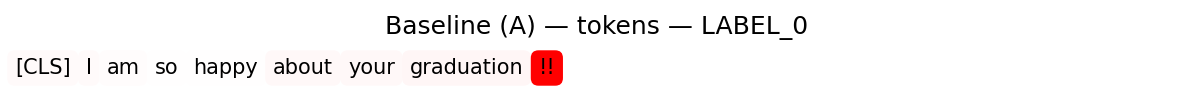

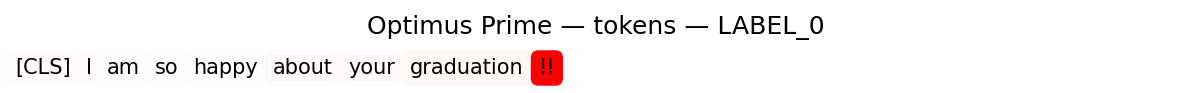

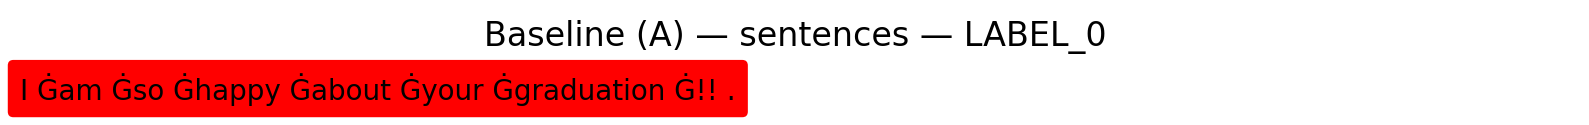

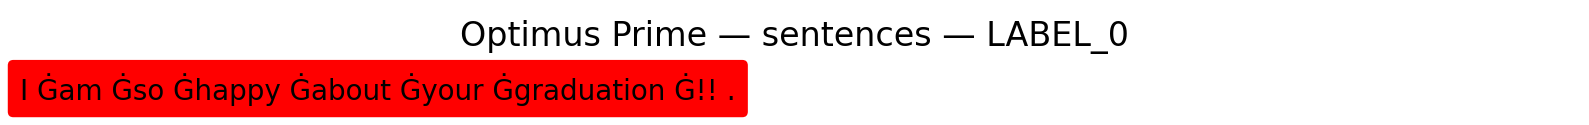

In [22]:

# ===== 0) CONFIG =====
MODEL_ID = "roberta-base"   # RoBERTa emotion model or change to emoberta
TASK = "single_label"               # or "multi_label"
TEXT = ("I am so happy about your graduation !!.")

# ===== 1) Deps =====
!pip -q install --upgrade pip
!pip -q install "transformers>=4.41" "torch>=2.2" numpy matplotlib
# Optional; if it fails, we shim and still run attention-based Optimus:
!pip -q install "transformers-interpret>=0.9.6" || true

# ===== 2) Clone Optimus & set path =====
import os, sys, numpy as np, matplotlib.pyplot as plt

repo_dir = "/content/optimus_repo"
if not os.path.exists(repo_dir):
    !git clone -q https://github.com/intelligence-csd-auth-gr/Optimus-Transformers-Interpretability.git {repo_dir}
os.chdir(repo_dir)
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# ===== 3) Safe shim for transformers_interpret (non-throwing on __init__) =====
import sys as _sys, types, importlib
# Purge any cached bad shim/import
for k in list(_sys.modules):
    if k == "transformers_interpret" or k.startswith("transformers_interpret."):
        _sys.modules.pop(k, None)
try:
    import transformers_interpret  # if this works, great
except Exception:
    class _DummySequenceClassificationExplainer:
        def __init__(self, *args, **kwargs):
            self.model = args[0] if args else kwargs.get("model", None)
            self.tokenizer = kwargs.get("tokenizer", None)
        def __call__(self, *a, **k): raise RuntimeError("transformers-interpret not available; IG/LIME disabled.")
        def saliency_interpret(self, *a, **k): raise RuntimeError("transformers-interpret not available; IG/LIME disabled.")
        def integrated_gradients(self, *a, **k): raise RuntimeError("transformers-interpret not available; IG/LIME disabled.")
        def lime(self, *a, **k): raise RuntimeError("transformers-interpret not available; IG/LIME disabled.")
    ti = types.ModuleType("transformers_interpret")
    ti.SequenceClassificationExplainer = _DummySequenceClassificationExplainer
    _sys.modules["transformers_interpret"] = ti

# ===== 4) HF wrapper + trainer shim (what Optimus expects) =====
import torch
from types import SimpleNamespace
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class _DummyTrainer:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = next(model.parameters()).device

    @torch.inference_mode()
    def predict(self, dataset):
        # Try to get raw texts; fallback to decoding
        texts = None
        for attr in ["set_of_instance", "instances", "texts", "samples", "data", "inputs", "input_texts", "instance"]:
            if hasattr(dataset, attr):
                val = getattr(dataset, attr)
                if isinstance(val, (list, tuple)): texts = list(val)
                elif isinstance(val, str):         texts = [val]
                if texts: break
        if texts is None and hasattr(dataset, "__len__") and hasattr(dataset, "__getitem__"):
            try:
                texts = []
                for i in range(len(dataset)):
                    item = dataset[i]
                    if isinstance(item, (list, tuple)) and item and isinstance(item[0], str):
                        texts.append(item[0])
                    elif isinstance(item, dict) and "text" in item:
                        texts.append(item["text"])
                    elif isinstance(item, dict) and "input_ids" in item:
                        ids = item["input_ids"]
                        ids = ids.tolist() if hasattr(ids, "tolist") else ids
                        texts.append(self.tokenizer.decode(ids, skip_special_tokens=True))
            except Exception:
                pass
        if not texts: texts = [""]

        logits_list, hidden_list, attn_list = [], [], []
        for text in texts:
            enc = self.tokenizer(text, return_tensors="pt", truncation=True, padding=False,
                                 add_special_tokens=True, return_attention_mask=True)
            enc = {k: v.to(self.device) for k, v in enc.items()}
            out = self.model(**enc, output_attentions=True, output_hidden_states=True, return_dict=True)
            logits_list.append(out.logits.detach().cpu().numpy())                                # (1,C)
            hidden_list.append(np.stack([h.detach().cpu().numpy() for h in out.hidden_states],  # (L+1,1,T,D)
                                        axis=0))
            attn_list.append(np.stack([a.detach().cpu().numpy() for a in out.attentions],        # (L,1,H,T,T)
                                       axis=0))

        logits = np.concatenate(logits_list, axis=0)                                 # (B,C)
        hidden = np.concatenate(hidden_list, axis=1) if len(hidden_list)>1 else hidden_list[0]
        attns  = np.concatenate(attn_list,  axis=1) if len(attn_list)>1  else attn_list[0]
        return SimpleNamespace(predictions=(logits, hidden, attns))

class HFModelWrapper:
    def __init__(self, model_id=MODEL_ID, task=TASK, device=None):
        self.id = model_id
        self.task = task
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(self.id, use_fast=True)
        self._hf_model = AutoModelForSequenceClassification.from_pretrained(self.id, output_attentions=True).to(self.device).eval()
        self.trainer = _DummyTrainer(self._hf_model, self.tokenizer)
        self.num_labels = self._hf_model.config.num_labels
        self.label_names = [self._hf_model.config.id2label[i] for i in range(self.num_labels)]
        self.bos_token = self.tokenizer.bos_token or "<s>"
        self.eos_token = self.tokenizer.eos_token or "</s>"
        self.pad_tokens = {"<pad>", "[PAD]"}

    @torch.inference_mode()
    def predict_proba(self, text: str):
        enc = self.tokenizer(text, return_tensors="pt", truncation=True, padding=False,
                             add_special_tokens=True, return_attention_mask=True)
        enc = {k: v.to(self.device) for k, v in enc.items()}
        out = self._hf_model(**enc, output_attentions=True, output_hidden_states=True, return_dict=True)
        if self.task == "multi_label":
            return torch.sigmoid(out.logits).detach().cpu().numpy()[0]
        return torch.softmax(out.logits, dim=-1).detach().cpu().numpy()[0]

# ===== 5) Import Optimus & load model =====
import optimus; importlib.reload(optimus)  # ensure it sees our shim
from optimus import Optimus, plot_text_heatmap, plot_sentence_heatmap

wrapper = HFModelWrapper(MODEL_ID, TASK)
label_names = wrapper.label_names

# Small calibration pool
calib = [
    "I feel incredibly happy today!",
    "This makes me anxious and a bit afraid.",
    "I'm grateful for your help.",
    "I am angry about the delay.",
]
ionbot = Optimus(wrapper, wrapper.tokenizer, label_names, task=TASK, set_of_instance=calib)

# ===== 6) Explain (Baseline & Prime) =====
# token-level
scores_tok_b, toks_b = ionbot.explain(TEXT, mode="baseline",         level="token",    raw_attention="A")
scores_tok_p, toks_p = ionbot.explain(TEXT, mode="max_per_instance", level="token",    raw_attention="A")
# sentence-level
scores_sent_b, sents = ionbot.explain(TEXT, mode="baseline",         level="sentence", raw_attention="A")
scores_sent_p, _     = ionbot.explain(TEXT, mode="max_per_instance", level="sentence", raw_attention="A")

# ===== 7) Utilities to make RoBERTa tokens pretty & safe =====
SPECIALS = {wrapper.bos_token, wrapper.eos_token} | wrapper.pad_tokens

def roberta_pretty_tokens(tokens):
    """Remove RoBERTa space mark (Ġ) and map BOS/EOS to readable tags."""
    out = []
    for t in tokens:
        if t == wrapper.bos_token: out.append("[CLS]"); continue
        if t == wrapper.eos_token: out.append("[SEP]"); continue
        out.append(t.replace("Ġ", ""))  # drop space marker; plot lib handles spacing per token
    return out

def strip_specials_align(tokens, scores_2d):
    """Cast to NumPy, align lengths, drop specials if any remain."""
    arr = np.asarray(scores_2d, dtype=float)
    T = min(arr.shape[1], len(tokens))
    toks = list(tokens)[:T]
    arr  = arr[:, :T]
    keep = [i for i, t in enumerate(toks) if t not in SPECIALS]
    if keep:  # only drop if something remains; else keep all to avoid empties
        toks = [toks[i] for i in keep]
        arr  = arr[:, keep]
    return toks, arr

# Preprocess for plotting (Baseline/Prime tokens handled separately, then aligned if needed)
toks_b_pp = roberta_pretty_tokens(toks_b)
toks_p_pp = roberta_pretty_tokens(toks_p)
toks_b_pp, scores_tok_b = strip_specials_align(toks_b_pp, scores_tok_b)
toks_p_pp, scores_tok_p = strip_specials_align(toks_p_pp, scores_tok_p)

# ===== 8) Pick top label and plot (built-in heatmaps only) =====
probs = wrapper.predict_proba(TEXT)
pred_idx = int(np.argmax(probs))
pred_label = label_names[pred_idx]
print("Top label:", pred_label, "| probs:", dict(zip(label_names, np.round(probs, 3))))

# Token heatmaps (Baseline & Prime) — predicted label only
plot_text_heatmap(toks_b_pp, scores_tok_b[pred_idx])
plt.title(f"Baseline (A) — tokens — {pred_label}")
plt.show()

# Align token lengths for Prime if they differ (use the shorter)
T = min(len(toks_b_pp), len(toks_p_pp), scores_tok_b.shape[1], scores_tok_p.shape[1])
plot_text_heatmap(toks_p_pp[:T], scores_tok_p[pred_idx, :T])
plt.title(f"Optimus Prime — tokens — {pred_label}")
plt.show()

# Sentence heatmaps (Baseline & Prime)
plot_sentence_heatmap(sents, scores_sent_b[pred_idx])
plt.title(f"Baseline (A) — sentences — {pred_label}")
plt.show()

plot_sentence_heatmap(sents, scores_sent_p[pred_idx])
plt.title(f"Optimus Prime — sentences — {pred_label}")
plt.show()
